In [1]:
import sys
import os
import toml

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import scipy.optimize as SciOpt
from scipy.special import rel_entr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm
from copy import deepcopy

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.data_generators import DataGenerator
from lsm.lsmtype import Policy
import lsm.cost as CostFunc
import lsm.solver as Solvers

In [2]:
config = Reader.read_config('../../endure.toml')
data_gen = DataGenerator(config)
wls = config['workloads']
# models = ['Robust', 'DostF', 'LL', 'Y1', 'YZ', 'Q', 'K', 'Tier', 'Level']
models = ['Robust', 'DostF', 'LL', 'Level']
RHO = 0

In [3]:
cf = CostFunc.EndureLevelCost(config)
cf_l = CostFunc.EndureLevelTrueCost(config)
cf(0.25, 2, 0.25, 0.25, 0.25, 0.25), cf_l(0.25, 2, 0.25, 0.25, 0.25, 0.25)

(10.193980548612041, 9.773463711412266)

In [4]:
def get_nominal_tunings(workload):
    tunings = {model: get_nominal_tuning(workload, model=model) for model in models}
    return tunings

def get_nominal_tuning(workload, model='K'):
    solvers = {
        'Robust': Solvers.EndureLevelSolver,
        'DostF': Solvers.EndureDostoevskyFixedSolver,
        'LL': Solvers.EndureLazyLevelingSolver,
        'Y1': Solvers.EndureYSolver,
        'YZ': Solvers.EndureYZSolver,
        'Q': Solvers.EndureQSolver,
        'K': Solvers.EndureKSolver,
        'Tier': Solvers.EndureTierSolver,
        'Level': Solvers.EndureLevelSolver}
    # workload = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    z0, z1, q, w = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    # z0, z1, q, w = workload
    solver = solvers.get(model, None)
    if solver is None:
        print('Invalid model')
        return None
    solver = solver(config)
    if model == 'Robust':
        design = solver.find_robust_design(4, z0, z1, q, w)
        design.x = design.x[:-2]  # Remove lambda and eta
        # design.x[0] = 1.0
        # design.x[1] = 5.5
        # design.x = np.ndarray([1., 5.5])
    else:
        design = solver.find_nominal_design(z0, z1, q, w)
    tuning = {'design': design, 'solver': solver}
    return tuning

In [5]:
def sample_workloads(samples=10000):
    wls = []
    for _ in range(samples):
        wls.append(data_gen._sample_workload(4))
    return wls

def kl_div(w0: np.array, w1: np.array):
    return np.sum(rel_entr(w0, w1))

In [6]:
def gen_workloads(w0: np.array) -> pd.DataFrame:
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    np.random.seed(0)
    samples = sample_workloads()
    distances = []
    for sample in samples:
        distances.append(
            {'workload': sample,
             'rho': kl_div(sample, w0)})
        
    return pd.DataFrame(distances)

In [7]:
def gen_costs(
    w0: dict[str, float],
    workloads: list[list[float]],
    tunings: dict[str, dict]
) -> pd.DataFrame:
    df = []
    w0 = np.array([w0[key] for key in ('z0', 'z1', 'q', 'w')])
    for wl in workloads:
        z0, z1, q, w = wl
        row = {'rho': kl_div(wl, w0), 'z0': z0, 'z1': z1, 'q': q, 'w': w}
        for key, val in tunings.items():
            row[key] = val['solver'].nominal_objective(val['design'].x, z0, z1, q, w)
        df.append(row)
    # Special case we will add our orignal workload
    z0, z1, q, w = w0
    row = {'rho': 0, 'z0': z0, 'z1': z1, 'q': q, 'w': w}
    for key, val in tunings.items():
        row[key] = val['solver'].nominal_objective(val['design'].x, z0, z1, q, w)
    df.append(row)
    return pd.DataFrame(df)

In [8]:
def create_and_plot(workload, samples, plot_error=False):
    tunings = {model: get_nominal_tuning(workload, model) for model in models}
    df = gen_costs(workload, samples, tunings)
    
    rho_bins = np.arange(0.1, 4.5, 0.2)
    rho_bins = list(zip(rho_bins, rho_bins[1:]))

    mean = []
    for low, high in rho_bins:
        mean.append(df[(df.rho > low) & (df.rho <= high)].mean().to_dict())
    mean = pd.DataFrame([df.iloc[-1].to_dict()] + mean)
    
    std = []
    for low, high in rho_bins:
        std.append(df[(df.rho > low) & (df.rho <= high)].std().to_dict())
    std = pd.DataFrame([df.iloc[-1].to_dict()] + std)
    
    fig, ax = plt.subplots()
    for key in tunings.keys():
        ax.plot(mean['rho'], mean[key], label=f'{key}')
        if plot_error:
            ax.fill_between(mean['rho'], mean[key] - std[key], mean[key] + std[key], alpha=0.5)
    ax.set_xlabel('Distance from $w_0$')
    ax.set_ylabel('C($\Phi$)')
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    ax.set_title(f'$w_0$: ($z_0$: {w0[0]:.0%}, $z_1$: {w0[1]:.0%}, $q$: {w0[2]:.0%}, $w$: {w0[3]:.0%})')
    _ = ax.legend()
    
    return df, mean, fig, ax

In [9]:
samples = sample_workloads()

/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 271
            Gradient evaluations: 42


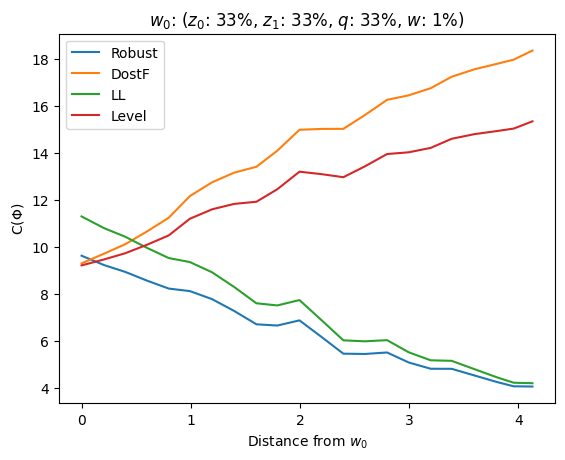

In [10]:
df, _, fig, ax = create_and_plot(wls[11], samples)

In [11]:
designs = get_nominal_tunings(wls[11])
for key, val in designs.items():
    print(f'{key} : {val["design"].x}')

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 271
            Gradient evaluations: 42
Robust : [4.75680253 6.16836554]
DostF : [46.69649897  1.          1.        ]
LL : [4.65405036 2.        ]
Level : [ 4.48165875 47.5521681 ]


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Hypothesis

H1: Flexible cost models provide best nominal performance (>=)

    - Only point read queries -> "True"
    - Write queries introdued -> True
    - Range queries introduced -> False

H2: Flexible cost models are inherently more robust

    - Only point read queries -> "False"
    - Write queries introdued -> False
    - Range queries introduced -> True

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 270
            Gradient evaluations: 42


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 277
            Gradient evaluations: 43


/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 275
            Gradient evaluations: 43


/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 42
            Function evaluations: 267
            Gradient evaluations: 41


/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 280
            Gradient evaluations: 42


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 5.187496695932689e+71
            Iterations: 35
            Function evaluations: 227
            Gradient evaluations: 35


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 286
            Gradient evaluations: 43


/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 280
            Gradient evaluations: 42


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 286
            Gradient evaluations: 43


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 42
            Function evaluations: 265
            Gradient evaluations: 41


/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 286
            Gradient evaluations: 43


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 271
            Gradient evaluations: 42


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 280
            Gradient evaluations: 42


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 34
            Function evaluations: 225
            Gradient evaluations: 33


/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 43
            Function evaluations: 270
            Gradient evaluations: 42


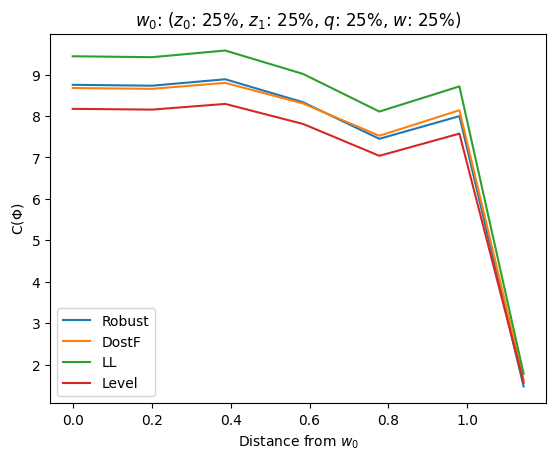

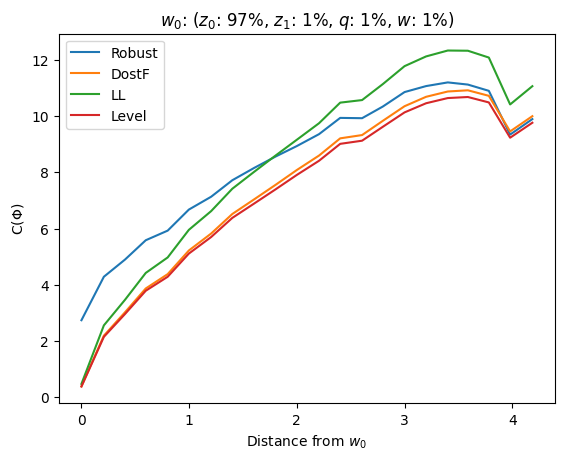

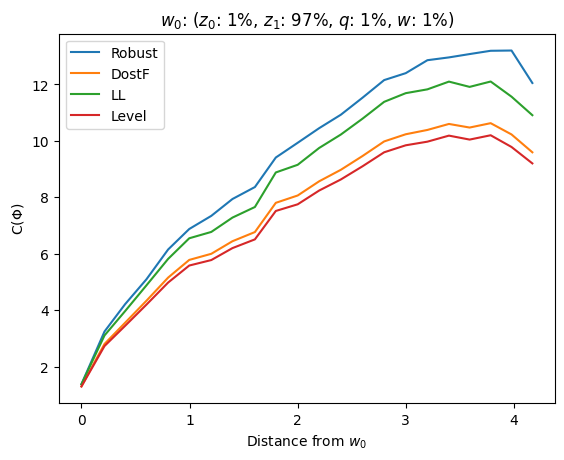

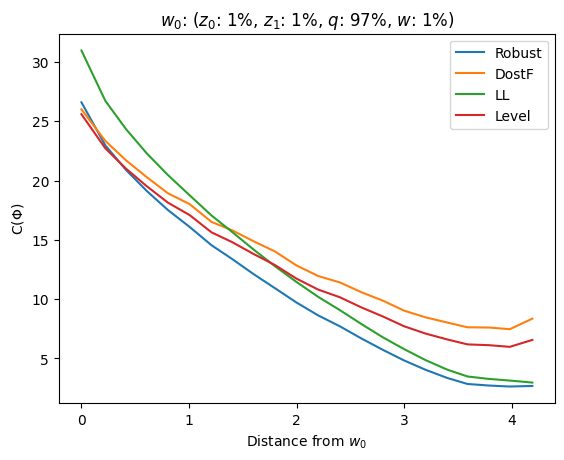

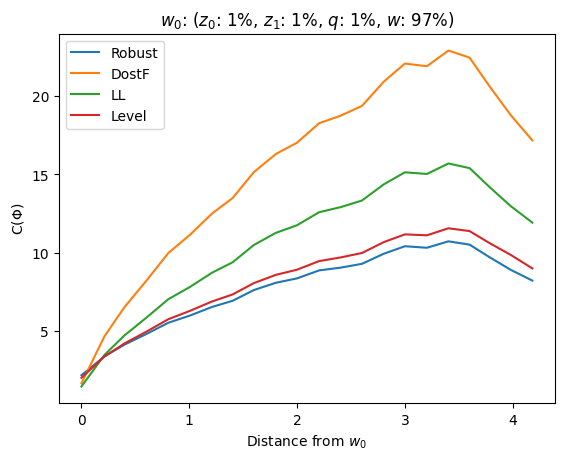

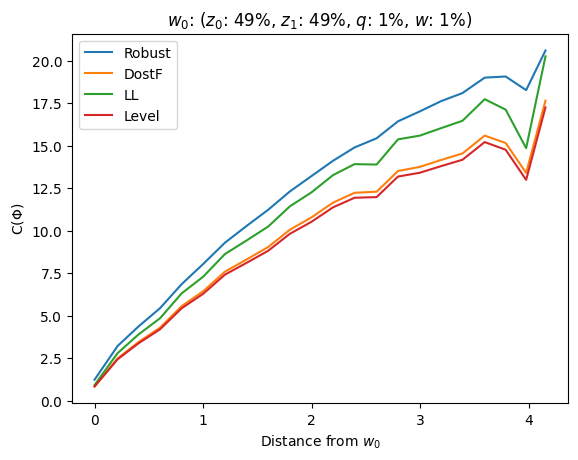

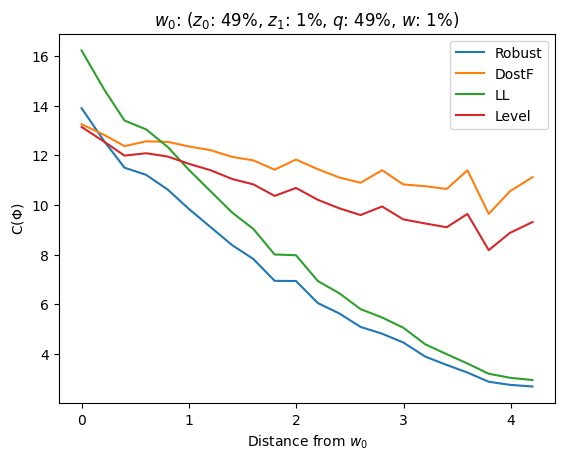

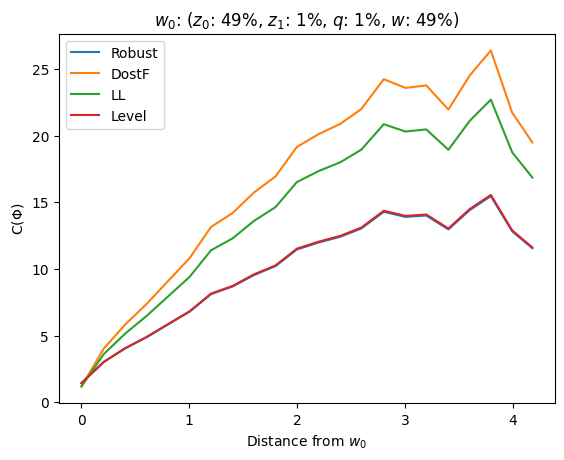

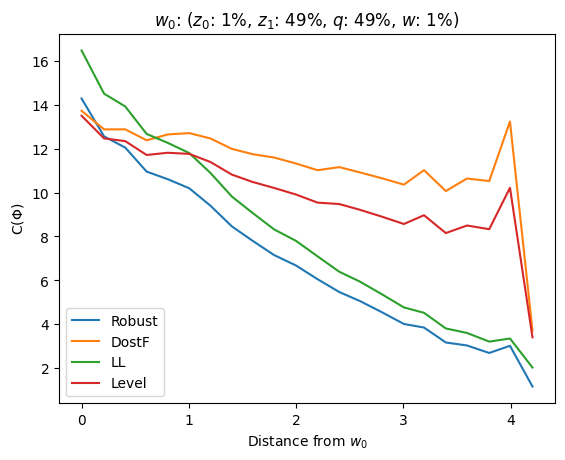

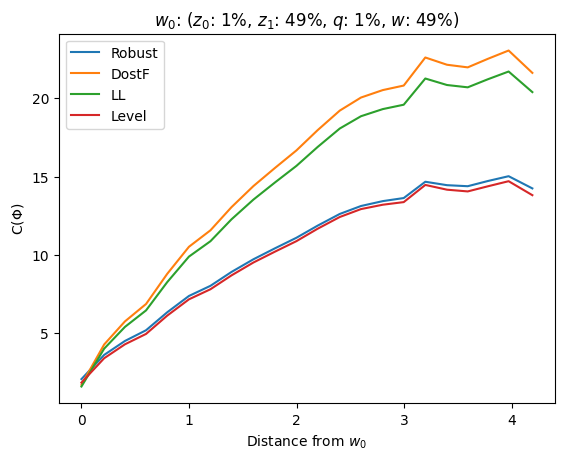

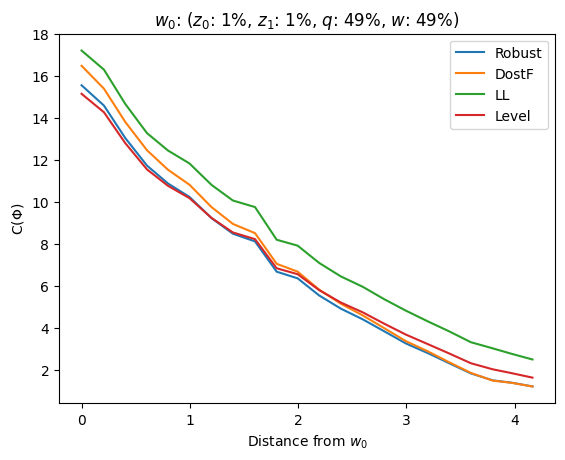

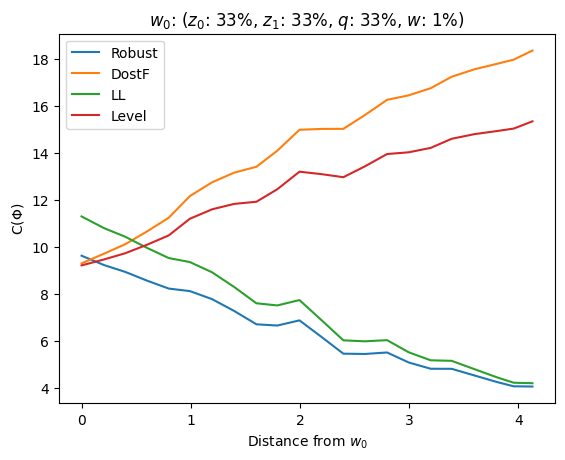

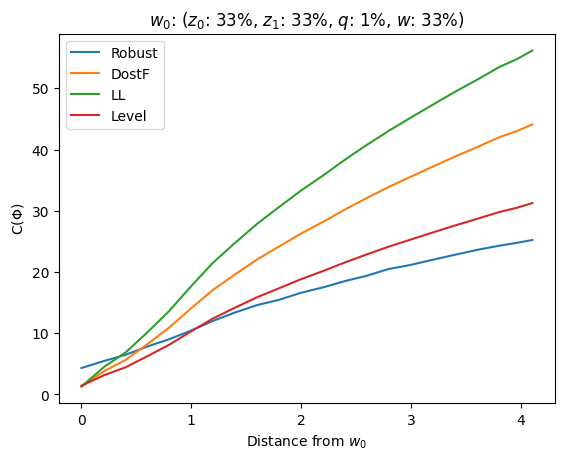

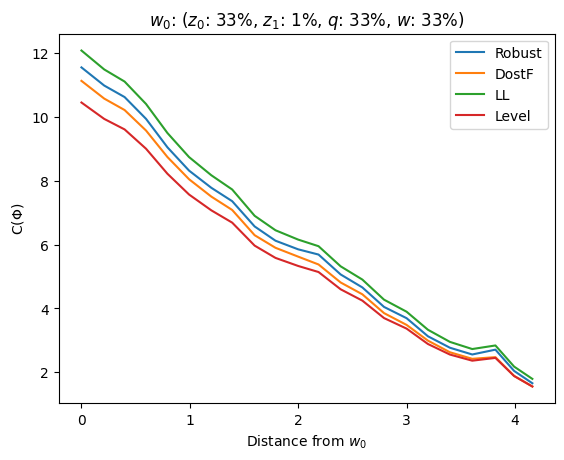

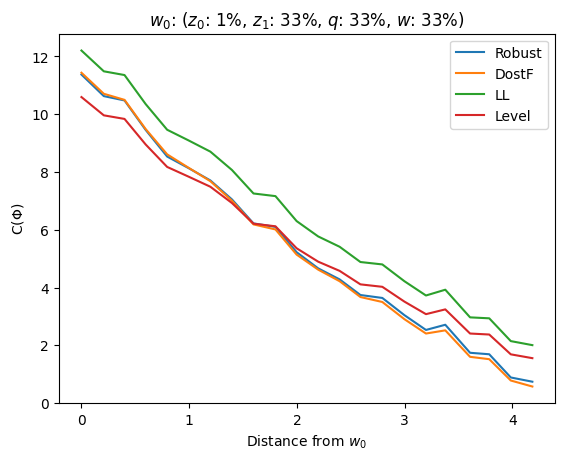

In [12]:
dfs = {}
for idx, workload in enumerate(wls):
    df, _, fig, ax = create_and_plot(workload, samples)
    dfs[idx] = df
    # fig.savefig(f'wl_{idx}.pdf')

In [13]:
def plot_rw_graph(workload, samples, model='K'):
    tuning = get_nominal_tuning(workload, model)
    rw = [sum([sample[0], sample[1], sample[3]]) for sample in samples]
    w0 = np.array([workload[key] for key in ('z0', 'z1', 'q', 'w')])
    rhos = [kl_div(sample, w0) for sample in samples]
    cost = [tuning['solver'].nominal_objective(tuning['design'].x, sample[0], sample[1], sample[2], sample[3]) for sample in samples]

    fig, ax = plt.subplots()
    cmap = plt.get_cmap('viridis')
    # norm = plt.Normalize(min(cost), max(cost))
    # ax.scatter(rw, rhos, c=cmap(norm(cost)))
    # norm = plt.Normalize(min(cost), max(cost))
    # ax.scatter(rhos, rw, c=cmap(norm(cost)))
    norm = plt.Normalize(min(rw), max(rw))
    ax.scatter(rhos, cost, c=cmap(norm(rw)))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm)
 
    cbar.set_label('Group 1 Percentage')
    ax.set_ylabel('$C(\phi)$')
    ax.set_xlabel('KL($\hat{w}$, $w_0$)')
    ax.set_title(f'Model: {model}, '
                 f'$w_0$: ($z_0$: {w0[0]:.0%}, $z_1$: {w0[1]:.0%}, $q$: {w0[2]:.0%}, $w$: {w0[3]:.0%})')
    return fig, ax

/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/ndhuynh/repos/endure/endure-torch/notebook/experiments/../../lsm/solver.py:23: RuntimeWarning: overflow encountered in exp
  return np.exp(input) - 1
/Users/ndhuynh/miniforge3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: inf
            Iterations: 44
            Function evaluations: 277
            Gradient evaluations: 43


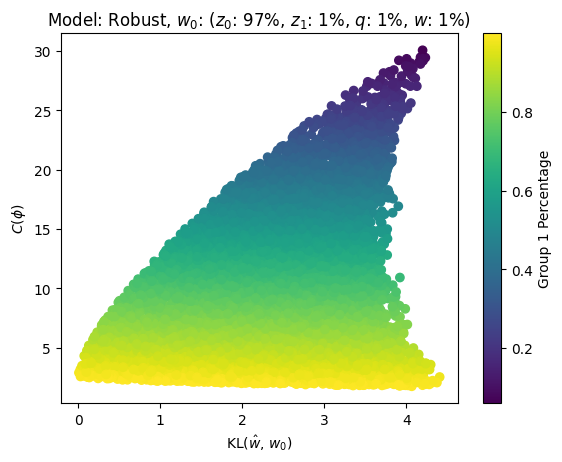

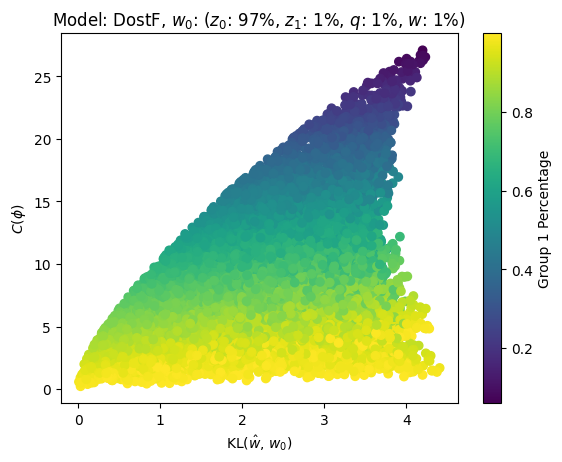

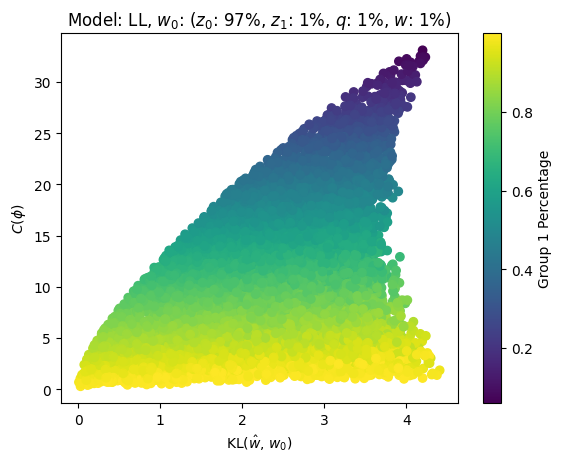

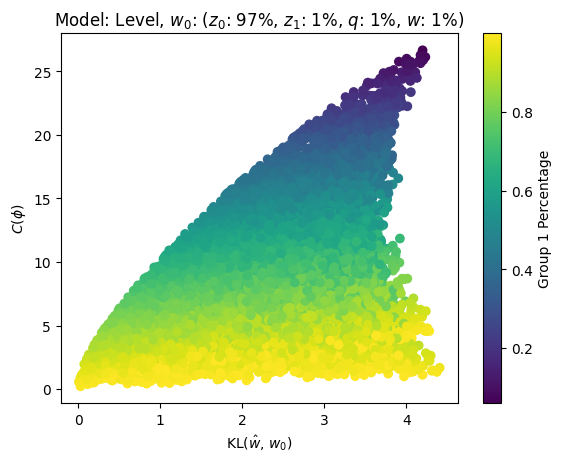

In [14]:
idx = 1
for model in models:
    old_fig, ax = plot_rw_graph(wls[idx], samples, model=model)